In [115]:
import numpy as np
import matplotlib.pyplot as plt
def read_csv(filename):
    arr = np.loadtxt(filename,
                 delimiter=",", skiprows=0, dtype=str)
    features = arr[0]
    arr = arr[1:-1]
    return arr,features
data,features = read_csv("DT_data.csv")
print(features)

label_num = 2
X = data
X = np.delete(data,obj=label_num,axis=1)
y = np.where(data[:, label_num].astype(int) <= 30000, 1, 0)  # 信誉度分类
features = np.delete(features,label_num)

['Undergrad' 'MaritalStatus' 'TaxableIncome' 'WorkExperience' 'Urban']


array(['Undergrad', 'MaritalStatus', 'WorkExperience', 'Urban'],
      dtype='<U14')

In [116]:

# 将文本特征转换为数值特征
X_encoded = np.zeros(X.shape)
for i in range(X.shape[1]):
    if i != 2:
        unique_labels = np.unique(X[:, i])
        label_mapping = {label: j for j, label in enumerate(unique_labels)}
        print(label_mapping)
        X_encoded[:, i] = np.array([label_mapping[label] for label in X[:, i]])

    else:
        X_encoded[:,i] = X[:,i]
#print(y)

{'NO': 0, 'YES': 1}
{'Divorced': 0, 'Married': 1, 'Single': 2}
{'NO': 0, 'YES': 1}


In [206]:
class Node:
    def __init__(self, feature=None, threshold=None, value=None,num=0):
        self.feature = feature
        self.threshold = threshold
        self.left = None
        self.right = None
        self.value = value
        self.num = num
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=10):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
    def gini_index(self,labels):
        #np.unique函数
        _,counts = np.unique(labels,return_counts=True)
        probs = counts / len(labels)
        gini = 1-np.sum(probs ** 2)
        
        return gini
    def split_dataset(self,X,y,feature,threshold):
        left_mask = X[:,feature] <= threshold
        right_mask = X[:,feature] > threshold
        #print('y[right_mask]',y[right_mask])
        return X[left_mask],y[left_mask], X[right_mask], y[right_mask]
    def get_best_split(self,X,y):
        best_feature,best_threshold, gini =None, None, np.inf
        y_left = y_right = None
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:,i])
            #print(thresholds)
            for threshold in thresholds:
                X_left,y_left,X_right,y_right = self.split_dataset(X,y,i,threshold)
                tmp_gini = (len(y_left)*self.gini_index(y_left) + len(y_right)*self.gini_index(y_right))/len(y)
                if tmp_gini < gini:
                    gini = tmp_gini
                    best_threshold = threshold
                    best_feature = i
        #print("best_feature ={} ,best_threshold={} ".format(best_feature,best_threshold))
        X_left,y_left,X_right,y_right = self.split_dataset(X,y,best_feature,best_threshold)
        #print("y_left and right:",y_left,y_right)
        if len(y_left)==0 or len(y_right)==0:
            # print("best_feature ={} ,best_threshold={} ".format(best_feature,best_threshold))
            # print(best_feature,best_threshold)
            # X_left,y_left,X_right,y_right = self.split_dataset(X,y,best_feature,best_threshold)
            # print('y_left',y_left,'y_right',y_right)
            return None,None,1
        return best_feature,best_threshold,gini
    def build_tree(self,X,y,depth=0):
        label = np.argmax(np.bincount(y))
        #注意两个中止条件
        # if len(y) == 0:
        #     return None
        if len(np.unique(y))==1:
        #只有叶子节点需要value,其他节点不需要
            #print(y[0])
            return Node(value=y[0], num=len(y))
        if depth>self.max_depth:
            return Node(value=label, num=len(y))
        best_feature,best_threshold,gini = self.get_best_split(X,y)
        if best_feature==None:
            return Node(value=label, num=len(y))
        #print("best_feature ={} ,best_threshold={} , depth={} ".format(features[best_feature],best_threshold,depth))

        node = Node(feature=best_feature,threshold=best_threshold,num= len(y),value=label)
        X_left,y_left,X_right,y_right = self.split_dataset(X,y,best_feature,best_threshold)
        node.left = self.build_tree(X_left,y_left,depth+1)
        node.right = self.build_tree(X_right,y_right,depth+1)
        return node
    #再封装一层
    def fit(self,X,y):
        self.root = self.build_tree(X,y)
    def prune_tree(self,node,X,y):
        
        if node.left == None and node.right == None:
            return
        if node.left != None:
           self.prune_tree(node.left,X,y)
        if node.right != None:
           self.prune_tree(node.right,X,y)# 这里没有return

        acc_before = self.cal_acc(X,y)
        temp_left = node.left
        temp_right = node.right
        if(temp_left.num>temp_right.num):
                node.value = temp_left.value
        else:
                node.value = temp_right.value

        node.left = None
        node.right = None   
        #print(temp_left==None)
        acc_after = self.cal_acc(X,y)
        #print("acc_before",acc_before,"acc_after",acc_after)
        if (acc_after<acc_before):
            node.left = temp_left
            node.right = temp_right
            #print("node.left ",node.left.value,"node.right ",node.right.value)
            #node.value = None
        # else:
        #     print('prune_tree',acc_before,acc_after)

    
    def predict(self,X):
        
        y = np.zeros(X.shape[0])
        for index,sample in enumerate(X):
            node = self.root
            while node.left !=None and node.right != None:
                feature = node.feature
                #print("node.threshold ",node.threshold)
                #print(sample[feature])
                if sample[feature] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            assert node.value!=None
            y[index] = node.value
        return y
    
    def cal_acc(self,X,y):
        cnt = 0
        pred = self.predict(X)
        #print(y)
        acc = np.sum(pred==y)/len(y)
        return acc

In [223]:
# 设置随机数种子,确保每次划分结果一致
np.random.seed(42)
# 计算测试集的样本数
test_size = int(X.shape[0] * 0.3)
K = 5 #5格交叉验证
fold_size = X.shape[0] // K
acc_list = []
# 重复 5 次划分过程
for i in range(K):
    val_start = i*fold_size
    val_end = (i+1)*fold_size
    np.random.seed(i)
    # 计算测试集的样本数
    test_size = int(data.shape[0] * 0.2)
    train_indices = np.concatenate((indices[:val_start], indices[val_end:])) #数组拼接
    # 按 80:20 的比例划分训练集和测试集
    indices = np.random.permutation(data.shape[0])
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train = X_encoded[train_indices, :]
    y_train = y[train_indices]
    X_val = X_encoded[val_start:val_end,:]
    y_val = y[val_start:val_end]
    X_test = X_encoded[test_indices, :]
    y_test = y[test_indices]
    
    # print(f"\n划分结果 {i+1}:")
    # print("训练集:")
    # print(X_train)
    # print(y_train)
    # print("测试集:")
    # print(X_test)
    # print(y_test)
    tree = DecisionTree(max_depth=10)
    tree.fit(X_train,y_train)
    print('accuracy before prune',tree.cal_acc(X_test,y_test))
    tree.prune_tree(tree.root,X_val,y_val)
    print('accuracy after prune ',tree.cal_acc(X_test,y_test))
    acc = tree.cal_acc(X_test,y_test)
    acc_list.append(acc)
print(acc_list)

accuracy before prune 0.7226890756302521
accuracy after prune  0.773109243697479
accuracy before prune 0.7563025210084033
accuracy after prune  0.7899159663865546
accuracy before prune 0.7058823529411765
accuracy after prune  0.773109243697479
accuracy before prune 0.7478991596638656
accuracy after prune  0.7899159663865546
accuracy before prune 0.7478991596638656
accuracy after prune  0.7983193277310925
[0.773109243697479, 0.7899159663865546, 0.773109243697479, 0.7899159663865546, 0.7983193277310925]


In [221]:
tree = DecisionTree(max_depth=3)
tree.fit(X_encoded,y)
tree.prune_tree(tree.root,X_encoded,y)
#print(tree.get_best_split(X_encoded,y))
print(tree.cal_acc(X_encoded,y))
# print(tree.cal_acc(X_encoded,y))


0.7929883138564274


In [222]:
def traverse(node,depth=0):
    if node==None:
        return 
    if node.left is None and node.right is None:
        print(node.value)
        return
    print("father_Node",features[node.feature],node.threshold,depth)
    traverse(node.left,depth+1)
    traverse(node.right,depth+1)
traverse(tree.root)

0


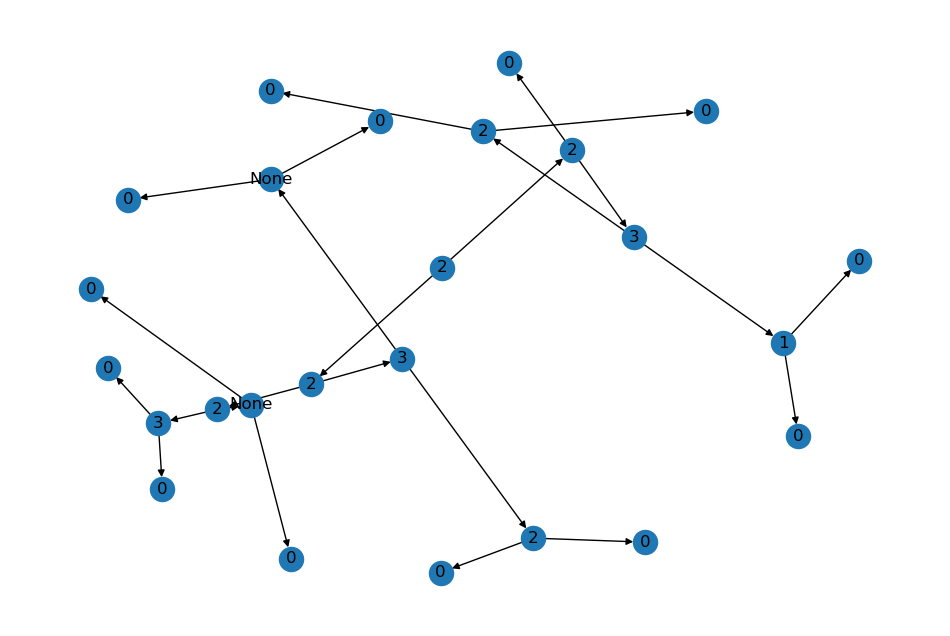

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_tree(root, feature_names=None):
    """
    Plots a decision tree using NetworkX and Matplotlib.
    
    Parameters:
    root (Node): The root node of the decision tree.
    feature_names (list): A list of feature names (optional).
    """
    G = nx.DiGraph()
    
    def dfs(node, parent=None):
        if node is None:
            return
        
        node_label = ""
        if node.feature is not None:
            if feature_names is not None:
                node_label += f"Feature {feature_names[node.feature]} <= {node.threshold}"
            else:
                node_label += f"Feature {node.feature} <= {node.threshold}"
        if node.value is not None:
            node_label += f"\nValue: {node.value}"
        
        G.add_node(node, label=node_label)
        if parent is not None:
            G.add_edge(parent, node)
        
        dfs(node.left, node)
        dfs(node.right, node)
    
    dfs(root)
    
    pos = nx.spring_layout(G)
    # for it in G.nodes():
    #     print(it.feature)
    fig, ax = plt.subplots(figsize=(12, 8))
    kv = {}
    for node in G.nodes:
        if node.feature:
            kv[node] = node.feature#features[node.feature]
        else:
            kv[node] = node.value
    nx.draw(G, pos, with_labels=True, labels=kv, ax=ax)
    plt.show()
plot_tree(tree.root,)

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graphviz

def plot_tree(root, feature_names=None):
    """
    Plots a decision tree using NetworkX and Matplotlib.
    
    Parameters:
    root (Node): The root node of the decision tree.
    feature_names (list): A list of feature names (optional).
    """
    G = nx.DiGraph()
    dot = graphviz.Digraph()
    
    def dfs(node, parent=None):
        if node is None:
            return
        
        node_label = ""
        if node.feature is not None:
            if feature_names is not None:
                node_label += f"Feature {feature_names[node.feature]}"
            else:
                node_label += f"Feature {node.feature}"
            node_label += f" <= {node.threshold}\nLeft: True\nRight: False"
        if node.value is not None:
            node_label += f"\nValue: {node.value}"
        
        dot.node(str(node.num), node_label)
        if parent is not None:
            if node.feature is not None:
                if node.threshold >= 0:
                    dot.edge(str(parent.num), str(node.num), label=f"{feature_names[node.feature]} <= {node.threshold}")
                else:
                    dot.edge(str(parent.num), str(node.num), label=f"{feature_names[node.feature]} > {-node.threshold}")
            else:
                dot.edge(str(parent.num), str(node.num), label=f"Value: {node.value}")
        
        dfs(node.left, node)
        dfs(node.right, node)
    
    dfs(root, None)
    
    dot.render('decision_tree', view=True)
plot_tree(tree.root,)

TypeError: 'NoneType' object is not subscriptable

best_feature =WorkExperience ,best_threshold=24.0 , depth=0 
best_feature =WorkExperience ,best_threshold=17.0 , depth=1 
best_feature =WorkExperience ,best_threshold=0.0 , depth=2 
best_feature =Undergrad ,best_threshold=0.0 , depth=3 
best_feature =Urban ,best_threshold=0.0 , depth=3 
best_feature =Urban ,best_threshold=0.0 , depth=2 
best_feature =Undergrad ,best_threshold=0.0 , depth=3 
best_feature =WorkExperience ,best_threshold=20.0 , depth=3 
best_feature =WorkExperience ,best_threshold=25.0 , depth=1 
best_feature =Urban ,best_threshold=0.0 , depth=2 
best_feature =MaritalStatus ,best_threshold=0.0 , depth=3 
best_feature =WorkExperience ,best_threshold=29.0 , depth=3 


TypeError: list indices must be integers or slices, not NoneType

In [95]:
X1,y1,X2,y2 = tree.split_dataset(X_encoded,y,2,29944)
print(y1,y2)
print(len(y2))

[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 

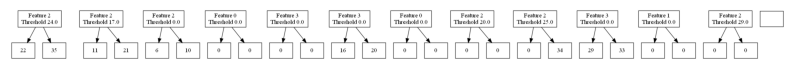

In [97]:
# 可视化决策树
import pydotplus
import graphviz
import os     
os.environ["PATH"] += os.pathsep + 'D:\\Apps\\anaconda3\\Graphviz\\bin'

dot_data = 'digraph Tree {\nnode [shape=box] ;\n'
def traverse_tree(node, index):
    global dot_data
    if node.left is None and node.right is None:
        dot_data += f'{index} [label="{node.value}"] ;\n'
        return index
    dot_data += f'{index} [label="Feature {node.feature}\\nThreshold {node.threshold}"] ;\n'
    left_index = traverse_tree(node.left, index + 1)
    right_index = traverse_tree(node.right, left_index + 1)
    dot_data += f'{index} -> {left_index} ;\n'
    dot_data += f'{index} -> {right_index} ;\n'
    return right_index + 1

traverse_tree(tree.root, 0)
dot_data += '}'
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('decision_tree.png')  # 保存决策树图像为PNG文件

# 通过Matplotlib显示决策树图像
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('decision_tree.png'))
plt.axis('off')
plt.show()

In [98]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt

# 构建决策树
iris = load_iris()
X = iris.data
y = iris.target

clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# 可视化决策树
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)

# 将dot源码转换为树状结构
def convert_dot_to_tree(dot_data):
    lines = dot_data.split('\n')
    print(lines)
    tree_structure = {}
    current_node = None
    for line in lines:
        if '[' in line:
            node_id = line.split(' ')[0]
            properties = line.split('[')[1].split(']')[0]
            if 'value' in properties:
                label = properties.split('"')[1]
                tree_structure[node_id] = {'value': label, 'children': []}
            else:
                feature = properties.split('=')[0]
                threshold = properties.split('=')[1].replace('<=', '<=').replace('>', '>')
                tree_structure[node_id] = {'feature': feature, 'threshold': threshold, 'children': []}
            if current_node is not None:
                tree_structure[current_node]['children'].append(node_id)
            current_node = node_id
    return tree_structure

tree_structure = convert_dot_to_tree(dot_data)

# 递归绘制决策树
def plot_tree(tree_structure, node_id):
    node = tree_structure[node_id]
    if 'value' in node:
        return node['value']
    else:
        feature = node['feature']
        threshold = node['threshold']
        children = node['children']
        child_labels = [plot_tree(tree_structure, child_id) for child_id in children]
        label = f'{feature}\n{threshold}'
        return [label] + child_labels

tree_plot_data = plot_tree(tree_structure, '0')

def tree_plot(ax, node, x, y, dx, dy):
    if isinstance(node, list):
        num_items = len(node)
        y_step = dy / (num_items + 1)
        y_start = y - dy / 2 + y_step / 2
        for i, item in enumerate(node):
            ax.text(x, y_start + i * y_step, item, ha='center', va='center')
            ax.plot([x, x - dx], [y - i * y_step, y - y_step], '-k')
    else:
        ax.text(x, y, node, ha='center', va='center')

        if 'children' in tree_structure[node]:
            children = tree_structure[node]['children']
            num_children = len(children)
            x_step = dx / (num_children + 1)
            x_start = x - dx / 2 + x_step / 2
            for i, child in enumerate(children):
                ax.plot([x, x - x_step], [y, y - dy], '-k')
                tree_plot(ax, child, x_start + i * x_step, y - dy, dx / 2, dy)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
tree_plot(ax, tree_plot_data, 0.5, 1, 1, 0)
plt.show()

['digraph Tree {', 'node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;', 'edge [fontname="helvetica"] ;', '0 [label=<petal length (cm) &le; 2.45<br/>gini = 0.667<br/>samples = 150<br/>value = [50, 50, 50]<br/>class = setosa>, fillcolor="#ffffff"] ;', '1 [label=<gini = 0.0<br/>samples = 50<br/>value = [50, 0, 0]<br/>class = setosa>, fillcolor="#e58139"] ;', '0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;', '2 [label=<petal width (cm) &le; 1.75<br/>gini = 0.5<br/>samples = 100<br/>value = [0, 50, 50]<br/>class = versicolor>, fillcolor="#ffffff"] ;', '0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;', '3 [label=<petal length (cm) &le; 4.95<br/>gini = 0.168<br/>samples = 54<br/>value = [0, 49, 5]<br/>class = versicolor>, fillcolor="#4de88e"] ;', '2 -> 3 ;', '4 [label=<gini = 0.041<br/>samples = 48<br/>value = [0, 47, 1]<br/>class = versicolor>, fillcolor="#3de684"] ;', '3 -> 4 ;', '5 [label=<gini = 0.444<br/>samples = 6<br/>value 

IndexError: list index out of range

In [ ]:
a = np.array([0,1,0,1,1,1,0])
np.argmax(np.bincount(a))

1

In [ ]:
a = np.array([1,0,1])
mask = a == 1
a[mask]

array([1, 1])

best_feature =2 ,best_threshold=1.9 , depth=0 


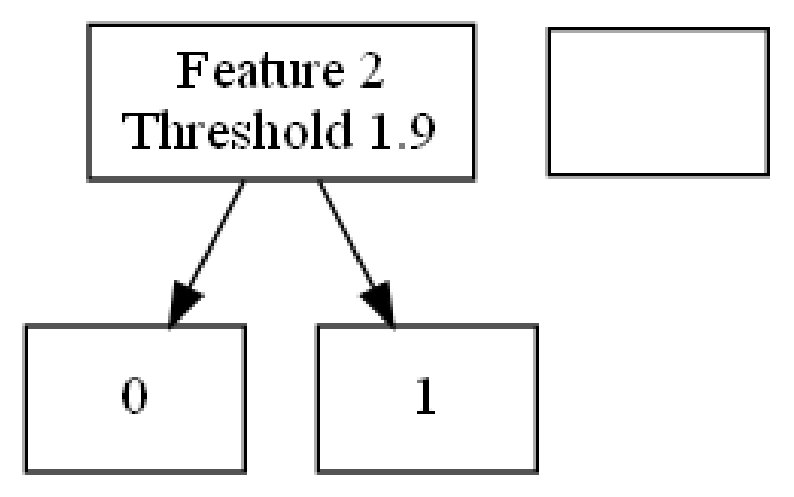

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt

#定义节点类和决策树类（使用之前提供的代码）

#构建决策树
iris = load_iris()
X = iris.data
y = iris.target

tree = DecisionTree(max_depth=3, min_samples_split=1)
tree.fit(X, y)

# 可视化决策树
dot_data = 'digraph Tree {\nnode [shape=box] ;\n'
def traverse_tree(node, index):
    global dot_data
    if node.left is None and node.right is None:
        dot_data += f'{index} [label="{node.value}"] ;\n'
        return index
    dot_data += f'{index} [label="Feature {node.feature}\\nThreshold {node.threshold}"] ;\n'
    left_index = traverse_tree(node.left, index + 1)
    right_index = traverse_tree(node.right, left_index + 1)
    dot_data += f'{index} -> {left_index} ;\n'
    dot_data += f'{index} -> {right_index} ;\n'
    return right_index + 1

traverse_tree(tree.root, 0)
dot_data += '}'
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('decision_tree.png')  # 保存决策树图像为PNG文件

# 通过Matplotlib显示决策树图像
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('decision_tree.png'))
plt.axis('off')
plt.show()

In [ ]:
print(y)

[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 

In [ ]:
labes=['有风险','好','有风险']
def gini(labels):
    # 计算Gini指数
    _, counts = np.unique(labels, return_counts=True)
    print(type(counts))
    probs = counts / len(labels)
    gini = 1 - np.sum(probs ** 2)
    return gini
gini(labes)

<class 'numpy.ndarray'>


0.4444444444444444

In [ ]:
# def split(X,y,feature,threshold):
#     left_mask = X[:,feature] <= threshold
#     right_mask = X[:,feature] > threshold
#     return X[left_mask],y[left_mask],X[right_mask],y[right_mask]
# for feature in range(X.shape[1]):
#     thresholds = np.unique(X[:, feature])
#     print(thresholds)
#     for threshold in thresholds:
#         X_left, y_left, X_right, y_right = split(X, y, feature, threshold)
def get_best_split(X,y):
    best_feature,best_threshold, gini =None, None, np.inf
    for i in range(X.shape[1]):
        thresholds = np.unique(X[:,i])
        for threshold in thresholds:
            X_left,y_left,X_right,y_right = split_dataset(X,y,i,threshold)
            tmp_gini = (len(y_left)*gini_index(y_left) + len(y_right)*gini_index(y_right))/len(y)
            if tmp_gini < gini:
                gini = tmp_gini,best_threshold = threshold, best_feature = i
    return best_feature,best_threshold,gini
get_best_split(X,y)

NameError: name 'split_dataset' is not defined

In [ ]:
a = np.array([1,2,3])
print(list(a)==None)

False


In [ ]:
import numpy as np

# 定义节点类
class Node:
    def __init__(self, feature=None, threshold=None, label=None):
        self.feature = feature  # 分割特征的索引
        self.threshold = threshold  # 分割特征的阈值
        self.label = label  # 叶节点的类别
        self.left = None  # 左子树
        self.right = None  # 右子树

# 定义决策树类
class DecisionTree:
    def __init__(self):
        self.root = None  # 根节点

    def gini_index(self, labels):
        # 计算Gini指数
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / len(labels)
        gini = 1 - np.sum(probs ** 2)
        return gini

    def split_dataset(self, X, y, feature, threshold):
        # 根据特征和阈值分割数据集
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        return X_left, y_left, X_right, y_right

    def select_best_split(self, X, y):
        # 选择最佳的分割特征和阈值
        best_feature, best_threshold, best_gini = None, None, np.inf
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self.split_dataset(X, y, feature, threshold)
                gini = (len(y_left) * self.gini_index(y_left) + len(y_right) * self.gini_index(y_right)) / len(y)
                if gini < best_gini:
                    best_feature, best_threshold, best_gini = feature, threshold, gini
        return best_feature, best_threshold

    def build_tree(self, X, y):
        # 递归构建决策树
        if len(np.unique(y)) == 1:
            # 所有样本属于同一类别，创建叶节点
            return Node(label=y[0])
        best_feature, best_threshold = self.select_best_split(X, y)
        if best_feature is None or best_threshold is None:
            # 无法继续分割，创建叶节点，选择类别最多的类别作为标签
            label = np.argmax(np.bincount(y))
            return Node(label=label)
        X_left, y_left, X_right, y_right = self.split_dataset(X, y, best_feature, best_threshold)
        node = Node(feature=best_feature, threshold=best_threshold)
        node.left = self.build_tree(X_left, y_left)
        node.right = self.build_tree(X_right, y_right)
        return node

    def prune_tree(self, node, X, y):
        if node.left is None and node.right is None:
            # 叶节点，无法剪枝
            return
        if node.left is not None:
            self.prune_tree(node.left, X, y)
        if node.right is not None:
            self.prune_tree(node.right, X, y)
        # 尝试剪枝
        if node.left is not None and node.right is not None:
            # 计算剪枝前的误分类错误率
            y_pred = self.predict(X)
            error_before = np.sum(y_pred != y) / len(y)
            # 剪枝后的误分类错误率
            node.left = None
            node.right = None
            y_pred = self.predict(X)
            error_after = np.sum(y_pred != y) / len(y)
            if error_after >= error_before:
                # 剪枝后的错误率增加，恢复剪枝前的子树
                node.left = self.build_tree(X_left, y_left)
                node.right = self.build_tree(X_right, y_right)
                

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, sample in enumerate(X):
            node = self.root
            while node.left is not None and node.right is not None:
                if sample[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            y_pred[i] = node.label
        return y_pred

# 构建决策树并剪枝
data = np.array([['NO', 'Single', '68833', '10', 'YES'],
                ['YES', 'Divorced', '33700', '18', 'YES'],
                ['NO', 'Married', '36925', '30', 'YES'],
                ['YES', 'Divorced', '69967', '2', 'YES'],
                ['NO', 'Divorced', '47334', '0', 'YES'],
                ['YES', 'Married', '98592', '17', 'NO']])

labels = np.array(['Undergrad', 'MaritalStatus', 'TaxableIncome', 'WorkExperience', 'Urban'])

X = data[:, :-1]  # 特征向量
y = data[:, -1]  # 类别标签

# 将文本特征转换为数值特征
X_encoded = np.zeros(X.shape)
for i in range(X.shape[1]):
    unique_labels = np.unique(X[:, i])
    label_mapping = {label: j for j, label in enumerate(unique_labels)}
    X_encoded[:, i] = np.array([label_mapping[label] for label in X[:, i]])

tree = DecisionTree()
tree.fit(X_encoded, y)

# 执行剪枝
tree.prune_tree(tree.root, X_encoded, y)

# 预测新样本
new_sample = np.array(['NO', 'Single', '68833', '10'])
new_sample_encoded = np.zeros(new_sample.shape)
for i in range(new_sample.shape[0]):
    new_sample_encoded[i] = label_mapping[new_sample[i]]
prediction = tree.predict(new_sample_encoded.reshape(1, -1))
print(prediction)